In [ ]:
# send to database
# unique.to_sql('final_unique', engine)

In [2]:
# dependencies

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import datetime

db_password = "postgres"
db_user = "postgres"
db_name = "Youtube P3"
endpoint = 'youtube.cb1bticre0py.us-east-1.rds.amazonaws.com'

connection_string = f"postgresql://{db_user}:{db_password}@{endpoint}:5432/{db_name}"
engine = create_engine(connection_string)

og_data = pd.read_sql('SELECT * FROM final_unique;', con = engine)

In [3]:
# start here if you need to re-run instead of pulling from postgres in above cell

final_unique = og_data.copy()

In [4]:
## chose target_days for classification model

target_df = pd.DataFrame(final_unique[['video_id', 'trend_days']])

target_days = 8   #     <---- pick your target days here

# prints statement below
print(target_df[target_df.trend_days > target_days].count())
print(target_df[target_df.trend_days > 0].count())              
print(round((target_df[target_df.trend_days > target_days].count()) / (target_df[target_df.trend_days > 0].count()),4))     

#             ↓↓↓↓↓  videos above days threshold / total videos / % of dataset above days threshold

video_id      20508
trend_days    20508
dtype: int64
video_id      241112
trend_days    241112
dtype: int64
video_id      0.0851
trend_days    0.0851
dtype: float64


In [5]:
# create dataset with 50/50 > and < outcomes

over_target = final_unique[final_unique.trend_days > target_days]
under_target = final_unique[final_unique.trend_days <= target_days].sample(n=20508)  # <--- copy & paste top output of last cell

df = pd.concat([over_target, under_target]).reset_index(drop=True)

# add target to column to new 50/50 dataset

df['target'] = df.trend_days > target_days
df['target'] = df['target'].astype(int) # makes 1 or 0 for T or F

df.reset_index(drop=True, inplace=True)

print(over_target.shape)
print(under_target.shape)
print(df.shape)
print(" ")
df.columns

(20508, 34)
(20508, 34)
(41016, 35)
 


Index(['index', 'video_id', 'category', 'category_e', 'country',
       'publish_date', 'trending_date', 'publish_to_trend', 'publish_day',
       'publish_day_num', 'combined_trend_days', 'trend_days', 'views',
       'pt_views', 'wt_views', 'pt_views_rate', 'wt_views_rate', 'likes',
       'pt_likes', 'wt_likes', 'pt_likes_rate', 'wt_likes_rate', 'likes_ratio',
       'dislikes', 'pt_dislikes', 'wt_dislikes', 'pt_dislikes_rate',
       'wt_dislikes_rate', 'comments', 'pt_comments', 'wt_comments',
       'pt_comments_rate', 'wt_comments_rate', 'comments_ratio', 'target'],
      dtype='object')

In [6]:
# chose your features

X = df[[
    'category_e',
    'publish_to_trend',
    'publish_day_num',
    'pt_views',
    'pt_likes',
    'pt_dislikes',
    'pt_comments',
    'likes_ratio',
    'comments_ratio'
    ]].to_numpy()

y = df['target'].to_numpy()

In [7]:
# scaling and splitting

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sclr  = scaler.fit(X)
X_scaled = sclr.transform(X)

from sklearn.model_selection import train_test_split

X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y,random_state=1)

print(X_train_scaled.shape)
print(y_train.shape)

(30762, 9)
(30762,)


In [8]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

In [9]:
 # amount of fittings = weights + leafs + n_neighbors

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [25, 29,33, 37, 41, 44, 49, 53, 57, 61],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 50, 100, 500]
}
grid_clf = GridSearchCV(model, param_grid, verbose=3)

In [12]:
# Fit the model using the grid search estimator by trying each combination of parameters.

grid_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END leaf_size=10, n_neighbors=25, weights=uniform;, score=0.957 total time=   0.7s
[CV 2/5] END leaf_size=10, n_neighbors=25, weights=uniform;, score=0.955 total time=   0.6s
[CV 3/5] END leaf_size=10, n_neighbors=25, weights=uniform;, score=0.959 total time=   0.7s
[CV 4/5] END leaf_size=10, n_neighbors=25, weights=uniform;, score=0.959 total time=   0.6s
[CV 5/5] END leaf_size=10, n_neighbors=25, weights=uniform;, score=0.951 total time=   0.6s
[CV 1/5] END leaf_size=10, n_neighbors=25, weights=distance;, score=0.958 total time=   0.6s
[CV 2/5] END leaf_size=10, n_neighbors=25, weights=distance;, score=0.956 total time=   0.6s
[CV 3/5] END leaf_size=10, n_neighbors=25, weights=distance;, score=0.960 total time=   0.6s
[CV 4/5] END leaf_size=10, n_neighbors=25, weights=distance;, score=0.960 total time=   0.6s
[CV 5/5] END leaf_size=10, n_neighbors=25, weights=distance;, score=0.952 total time=   0.6s
[CV 1/5] END 

[CV 4/5] END leaf_size=10, n_neighbors=57, weights=distance;, score=0.956 total time=   0.9s
[CV 5/5] END leaf_size=10, n_neighbors=57, weights=distance;, score=0.951 total time=   0.9s
[CV 1/5] END leaf_size=10, n_neighbors=61, weights=uniform;, score=0.956 total time=   1.0s
[CV 2/5] END leaf_size=10, n_neighbors=61, weights=uniform;, score=0.954 total time=   1.0s
[CV 3/5] END leaf_size=10, n_neighbors=61, weights=uniform;, score=0.957 total time=   1.1s
[CV 4/5] END leaf_size=10, n_neighbors=61, weights=uniform;, score=0.957 total time=   1.0s
[CV 5/5] END leaf_size=10, n_neighbors=61, weights=uniform;, score=0.949 total time=   1.0s
[CV 1/5] END leaf_size=10, n_neighbors=61, weights=distance;, score=0.956 total time=   0.9s
[CV 2/5] END leaf_size=10, n_neighbors=61, weights=distance;, score=0.954 total time=   0.9s
[CV 3/5] END leaf_size=10, n_neighbors=61, weights=distance;, score=0.958 total time=   0.9s
[CV 4/5] END leaf_size=10, n_neighbors=61, weights=distance;, score=0.957 t

[CV 3/5] END leaf_size=50, n_neighbors=53, weights=distance;, score=0.958 total time=   0.7s
[CV 4/5] END leaf_size=50, n_neighbors=53, weights=distance;, score=0.956 total time=   0.6s
[CV 5/5] END leaf_size=50, n_neighbors=53, weights=distance;, score=0.950 total time=   0.6s
[CV 1/5] END leaf_size=50, n_neighbors=57, weights=uniform;, score=0.956 total time=   0.7s
[CV 2/5] END leaf_size=50, n_neighbors=57, weights=uniform;, score=0.954 total time=   0.7s
[CV 3/5] END leaf_size=50, n_neighbors=57, weights=uniform;, score=0.957 total time=   0.7s
[CV 4/5] END leaf_size=50, n_neighbors=57, weights=uniform;, score=0.956 total time=   0.7s
[CV 5/5] END leaf_size=50, n_neighbors=57, weights=uniform;, score=0.950 total time=   0.7s
[CV 1/5] END leaf_size=50, n_neighbors=57, weights=distance;, score=0.957 total time=   0.7s
[CV 2/5] END leaf_size=50, n_neighbors=57, weights=distance;, score=0.954 total time=   0.7s
[CV 3/5] END leaf_size=50, n_neighbors=57, weights=distance;, score=0.958 t

[CV 1/5] END leaf_size=100, n_neighbors=49, weights=distance;, score=0.957 total time=   0.8s
[CV 2/5] END leaf_size=100, n_neighbors=49, weights=distance;, score=0.954 total time=   0.7s
[CV 3/5] END leaf_size=100, n_neighbors=49, weights=distance;, score=0.958 total time=   0.8s
[CV 4/5] END leaf_size=100, n_neighbors=49, weights=distance;, score=0.956 total time=   0.8s
[CV 5/5] END leaf_size=100, n_neighbors=49, weights=distance;, score=0.951 total time=   0.7s
[CV 1/5] END leaf_size=100, n_neighbors=53, weights=uniform;, score=0.955 total time=   0.9s
[CV 2/5] END leaf_size=100, n_neighbors=53, weights=uniform;, score=0.954 total time=   0.8s
[CV 3/5] END leaf_size=100, n_neighbors=53, weights=uniform;, score=0.957 total time=   0.9s
[CV 4/5] END leaf_size=100, n_neighbors=53, weights=uniform;, score=0.956 total time=   0.8s
[CV 5/5] END leaf_size=100, n_neighbors=53, weights=uniform;, score=0.950 total time=   0.9s
[CV 1/5] END leaf_size=100, n_neighbors=53, weights=distance;, sc

[CV 4/5] END leaf_size=500, n_neighbors=44, weights=uniform;, score=0.957 total time=   1.2s
[CV 5/5] END leaf_size=500, n_neighbors=44, weights=uniform;, score=0.950 total time=   1.2s
[CV 1/5] END leaf_size=500, n_neighbors=44, weights=distance;, score=0.957 total time=   1.2s
[CV 2/5] END leaf_size=500, n_neighbors=44, weights=distance;, score=0.954 total time=   1.1s
[CV 3/5] END leaf_size=500, n_neighbors=44, weights=distance;, score=0.958 total time=   1.2s
[CV 4/5] END leaf_size=500, n_neighbors=44, weights=distance;, score=0.956 total time=   1.2s
[CV 5/5] END leaf_size=500, n_neighbors=44, weights=distance;, score=0.951 total time=   1.1s
[CV 1/5] END leaf_size=500, n_neighbors=49, weights=uniform;, score=0.955 total time=   1.3s
[CV 2/5] END leaf_size=500, n_neighbors=49, weights=uniform;, score=0.954 total time=   1.2s
[CV 3/5] END leaf_size=500, n_neighbors=49, weights=uniform;, score=0.957 total time=   1.3s
[CV 4/5] END leaf_size=500, n_neighbors=49, weights=uniform;, sco

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 50, 100, 500],
                         'n_neighbors': [25, 29, 33, 37, 41, 44, 49, 53, 57,
                                         61],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [14]:
# List the best parameters for this dataset
print(grid_clf.best_params_)

# List the best score
print(grid_clf.best_score_)

{'leaf_size': 10, 'n_neighbors': 25, 'weights': 'distance'}
0.9573824877838778


In [15]:
# Create the parameter object for the randomized search estimator.
# Try adjusting n_neighbors with values of 1 through 19. Adjust leaf_size by using a range from 1 to 500.
# Include both uniform and distance options for weights.
param_grid = {
    'n_neighbors': np.arange(11,31,2),
    'weights': ['uniform', 'distance'],
    'leaf_size': np.arange(1, 100)
}
param_grid

{'n_neighbors': array([11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'weights': ['uniform', 'distance'],
 'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
        86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])}

In [16]:
# Create the randomized search estimator by using the logistic regression model and the parameter grid that you created.
from sklearn.model_selection import RandomizedSearchCV

random_clf = RandomizedSearchCV(model, param_grid, random_state=0, verbose=3)

In [17]:
# Fit the model with randomized search estimator - feeding random samples of above param grid to the logistic model
random_clf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END leaf_size=35, n_neighbors=15, weights=uniform;, score=0.960 total time=   0.4s
[CV 2/5] END leaf_size=35, n_neighbors=15, weights=uniform;, score=0.957 total time=   0.4s
[CV 3/5] END leaf_size=35, n_neighbors=15, weights=uniform;, score=0.960 total time=   0.4s
[CV 4/5] END leaf_size=35, n_neighbors=15, weights=uniform;, score=0.961 total time=   0.4s
[CV 5/5] END leaf_size=35, n_neighbors=15, weights=uniform;, score=0.954 total time=   0.4s
[CV 1/5] END leaf_size=28, n_neighbors=29, weights=distance;, score=0.959 total time=   0.4s
[CV 2/5] END leaf_size=28, n_neighbors=29, weights=distance;, score=0.956 total time=   0.4s
[CV 3/5] END leaf_size=28, n_neighbors=29, weights=distance;, score=0.960 total time=   0.5s
[CV 4/5] END leaf_size=28, n_neighbors=29, weights=distance;, score=0.959 total time=   0.4s
[CV 5/5] END leaf_size=28, n_neighbors=29, weights=distance;, score=0.952 total time=   0.4s
[CV 1/5] END l

RandomizedSearchCV(estimator=KNeighborsClassifier(),
                   param_distributions={'leaf_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'n_neighbors': array([11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                                        'weights': ['uniform', 'distance']},
                   random_state=0, verbose=3)

In [18]:
print(random_clf.best_params_)

{'weights': 'distance', 'n_neighbors': 13, 'leaf_size': 39}


In [19]:
print(random_clf.best_score_)

0.9602756761531953


In [21]:
# Make predictions with the hypertuned model
predictions = random_clf.predict(X_test_scaled)

In [22]:
target_names = ['1', '0']

# Calculate the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

           1       0.99      0.94      0.96      5121
           0       0.94      0.99      0.96      5133

    accuracy                           0.96     10254
   macro avg       0.96      0.96      0.96     10254
weighted avg       0.96      0.96      0.96     10254



In [24]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = random_clf.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[4791,  330],
       [  59, 5074]], dtype=int64)

k: 3, Train/Test Score: 0.977/0.962
k: 5, Train/Test Score: 0.972/0.962
k: 7, Train/Test Score: 0.970/0.962
k: 9, Train/Test Score: 0.968/0.961
k: 11, Train/Test Score: 0.966/0.960
k: 13, Train/Test Score: 0.965/0.960
k: 15, Train/Test Score: 0.963/0.960
k: 17, Train/Test Score: 0.962/0.960
k: 19, Train/Test Score: 0.961/0.959
k: 21, Train/Test Score: 0.960/0.958
k: 23, Train/Test Score: 0.960/0.959
k: 25, Train/Test Score: 0.959/0.959
k: 27, Train/Test Score: 0.959/0.958
k: 29, Train/Test Score: 0.958/0.958


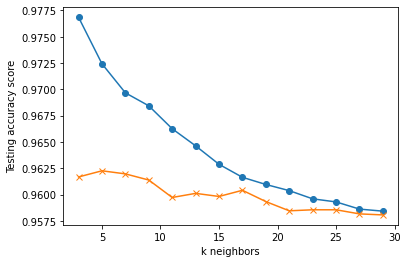

In [25]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []
for k in range(3, 31, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(3, 31, 2), train_scores, marker='o')
plt.plot(range(3, 31, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [27]:
y_true = y_test
y_pred = knn.predict(X_test_scaled)
cm = confusion_matrix(y_true, y_pred)
cm

array([[4725,  396],
       [  34, 5099]], dtype=int64)

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96      5121
           1       0.93      0.99      0.96      5133

    accuracy                           0.96     10254
   macro avg       0.96      0.96      0.96     10254
weighted avg       0.96      0.96      0.96     10254



In [29]:
# pairs adds up 1
knn.predict_proba(X_test_scaled[0:20])

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.37931034, 0.62068966],
       [0.        , 1.        ],
       [0.03448276, 0.96551724],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.03448276, 0.96551724],
       [1.        , 0.        ],
       [0.93103448, 0.06896552],
       [1.        , 0.        ],
       [0.        , 1.        ]])

In [30]:
from sklearn.metrics import roc_curve

y_pred_proba = knn.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

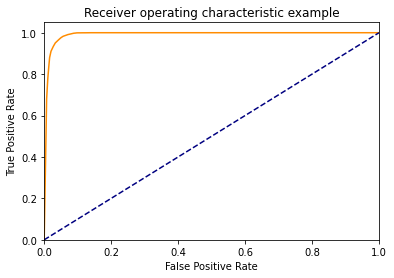

In [31]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [32]:
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)
roc_auc

0.9909615133751524